Imports


In [ ]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

In [ ]:
import os

NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")


import brax
from brax.envs.base import PipelineEnv, State
from brax import envs
from brax.io import mjcf
from brax import base
from brax.base import Transform
from brax import math

import brax.math
import jax
from jax import numpy as jp

import mujoco
from mujoco import mjx
from mujoco.mjx._src import support

#For training
from brax.training.agents.ppo import train as ppo
from brax.io import model
from datetime import datetime
import functools
from matplotlib import pyplot as plt

#visualizing
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl


# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [ ]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Rewards and Weights for the Walking Class

In [ ]:

WEIGHTS = {
    'velocity': 2,
    'base_height': 5,
    'control_cost': -1, # penalize control actions
    'rotation_cost': 0, # right now rotatation rewards aren't being given
    'upright_reward': 5
}


sensor_end_idx = {
    'position' : 3,
    'gyro' : 6,
    'local_linvel' : 9,
    'accelerometer' : 12,
    'upvector': 15,
    'forwardvector' : 18,
    'left_foot_force' : 21,
    'right_foot_force' : 24
}

# ===== REWARD FUNCTIONS =====
# reward for height of robot

# ===== REWARD FUNCTIONS =====
# reward for height of robot
@jax.jit
def _base_height_reward(sensor_data: jp.ndarray, min_height: float = 0.4, max_height: float = 0.6) -> float:
    """Compute base height reward"""

    position = sensor_data[ sensor_end_idx['position'] - 3 : sensor_end_idx['position'] ]


    current_height = position[2]

    in_range = jp.where(current_height > max_height, 0.0, 1)
    in_range = jp.where(current_height < min_height, 0.0, in_range)

    return in_range

# reward for forward velocity of a robot
@jax.jit
def _velocity_reward(pipeline_state) -> jp.ndarray:
    """Reward linear velocity"""

    # extract the xyz coordinates of the torso linear velocity (global frame)
    linear_velocity = pipeline_state.qvel[0:3]
    return linear_velocity[0]

@jax.jit

def _control_actions_reward(pipeline_state, prev_q):
    return jp.sum(jp.square(pipeline_state.q - prev_q))


@jax.jit
def _rotating_reward(sensor_data, roll_weight=1.0, pitch_weight=0.8, yaw_weight=0.6) -> jp.ndarray:
    """Compute uprightness reward"""
    angular_velocity = jp.array(sensor_data[ sensor_end_idx['gyro'] - 3 : sensor_end_idx['gyro'] ])

    roll_penalty = roll_weight * jp.abs(angular_velocity[0])
    pitch_penalty = pitch_weight * jp.abs(angular_velocity[1])
    yaw_penalty = yaw_weight * jp.abs(angular_velocity[2])

    return roll_penalty + pitch_penalty + yaw_penalty - 1 # prevent rewards from being too negative (- x - = +)


@jax.jit
def _upright_reward(sensor_data) -> jp.ndarray:
    upvector = jp.array(sensor_data[
        sensor_end_idx['upvector'] - 3 : sensor_end_idx['upvector']
    ])

    ideal_up = jp.array([0.0, 0.0, 1.0])  # World z-axis
    up_alignment = jp.dot(upvector, ideal_up)  # Ranges from -1 (upside down) to 1 (upright)

    # Exponential scaling to make it more sensitive near upright
    up_reward = jp.exp(5 * (up_alignment - 1))  # Adjust the exponent factor for sensitivity

    return up_reward

    #  model_path = "/content/drive/MyDrive/RoboCup/ernest_humanoid_og.xml"


    #  model_path = "/content/drive/MyDrive/RoboCup/ernest_humanoid_og.xml"


## Humanoid Walker Class

In [ ]:
class HumanoidWalker(PipelineEnv):
    def __init__(self, **kwargs):

        model_path = "/content/drive/MyDrive/RoboCup/ernest_humanoid_og.xml"
        mj_model = mujoco.MjModel.from_xml_path(model_path)

        self.mj_data = mujoco.MjData(mj_model)
        self.mjx_model = mjx.put_model(mj_model)

        self.sys = mjcf.load_model(mj_model)

        self.reset_noise_scale = 1e-2

        self.seed = jax.random.PRNGKey(0)

        super().__init__(self.sys, backend='mjx', **kwargs)

        # indeces of data
        self.accel_end_idx = 3
        self.gyro_end_idx = 6
        self.lin_accel_end_idx = 9


        self.target_height = 0.4
        self.roll_weight = 1.0
        self.pitch_weight = 0.8
        self.yaw_weight = 0.6

        #IMU Sensor and Contact Force
        self.num_sensors = sensor_end_idx['right_foot_force'] - 1
        self.sensor_data = jp.zeros(self.num_sensors)


        #Define size of arrays returned with sensor data
        self.sensor_sizes = {
            'position' : 3,
            'gyro' : 3,
            'local_linvel' : 3,
            'accelerometer' : 3,
            'upvector': 3,
            'forwardvector' : 3,
            'left_foot_force' : 3,
            'right_foot_force' : 3
        }



    def reset(self, rng: jp.ndarray) -> State:
        rng, rng1, rng2 = jax.random.split(rng, 3)

        low, hi = -self.reset_noise_scale, self.reset_noise_scale

        humanoid_qpos = self.sys.init_q + jax.random.uniform(
            rng1, (self.sys.q_size(),), jp.float32, minval=low, maxval=hi
        )

        humanoid_qvel = jax.random.uniform(
            rng2, (self.sys.qd_size(),), minval=low, maxval=hi
        )

        act = jp.zeros(self.sys.act_size(), jp.float32)

        #concatenate ball and goal positions and velocites into this below
        qpos = jp.concatenate([humanoid_qpos])
        qvel = jp.concatenate([humanoid_qvel])

        pipeline_state = self.pipeline_init(qpos, qvel, act)

        obs = self._get_obs(pipeline_state, act)



        reward, done, zero = jp.zeros(3)

        metrics = {
            'total_reward': zero,
            'velocity_reward': zero,
            'base_height_reward': zero,
            'control_cost': zero,
            'rotation_cost': zero,
            'upright_reward': zero,
        }

        return State(pipeline_state, obs, reward, done, metrics)

    def step(self, state: State, action: jp.ndarray) -> State:

        #normalize actions
        action_min = self.sys.actuator.ctrl_range[:, 0]
        action_max = self.sys.actuator.ctrl_range[:, 1]
        action = (action + 1) * (action_max - action_min) * 0.5 + action_min



        prev_q = state.pipeline_state.q
        #get pipeline state
        pipeline_state = self.pipeline_step(state.pipeline_state, action)


        # penalize changes in joint actions
        control_rewards = jp.sum(jp.square(pipeline_state.q - prev_q))

        #Get up to date observations
        obs = self._get_obs(pipeline_state, action)

        all_rewards, reward, done = self._calculate_reward(pipeline_state=pipeline_state,
                                                           sensor_data=obs,target_height=self.target_height, prev_q=prev_q)

        metrics = {
            'total_reward': reward,
            'velocity_reward': all_rewards['velocity'],
            'base_height_reward': all_rewards['base_height'],
            'control_cost': all_rewards['control_cost'],
            'rotation_cost': all_rewards['rotation_cost'],
            'upright_reward': all_rewards['upright_reward'],
        }


        #Replace data in state with newly acquired data
        return state.replace(pipeline_state=pipeline_state, obs=obs, reward=reward, done=done)


    def _get_obs(self, pipeline_state: base.State, action: jax.Array) -> jax.Array:

        #get sensor data
        sensor_data = pipeline_state.sensordata
        return sensor_data


    def _calculate_reward(self, pipeline_state, sensor_data, target_height, prev_q) -> float:
        "Calculate Rewards"

        all_rewards = {
            'velocity' : _velocity_reward(pipeline_state),
            'base_height' : _base_height_reward(sensor_data, target_height),
            'control_cost': _control_actions_reward(pipeline_state, prev_q),
            'rotation_cost': _rotating_reward(sensor_data, self.roll_weight, self.pitch_weight, self.yaw_weight),
            'upright_reward': _upright_reward(sensor_data)
        }
            # Calculate weighted sum of rewards

        REWARD_WEIGHT = jp.array([WEIGHTS[key] for key in all_rewards.keys()])
        reward_values = jp.array([all_rewards[key] for key in all_rewards.keys()])

        reward = jp.sum(REWARD_WEIGHT * reward_values)
        done = 1 - reward_values[1] # if the robot is 'not standing' we want to terminate the ep

        return all_rewards, reward, done

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Training

Metrics: {'eval/walltime': 50.948978424072266, 'eval/episode_base_height_reward': Array(0., dtype=float32), 'eval/episode_control_cost': Array(0., dtype=float32), 'eval/episode_reward': Array(756.608, dtype=float32), 'eval/episode_rotation_cost': Array(0., dtype=float32), 'eval/episode_total_reward': Array(0., dtype=float32), 'eval/episode_upright_reward': Array(0., dtype=float32), 'eval/episode_velocity_reward': Array(0., dtype=float32), 'eval/episode_base_height_reward_std': Array(0., dtype=float32), 'eval/episode_control_cost_std': Array(0., dtype=float32), 'eval/episode_reward_std': Array(154.19, dtype=float32), 'eval/episode_rotation_cost_std': Array(0., dtype=float32), 'eval/episode_total_reward_std': Array(0., dtype=float32), 'eval/episode_upright_reward_std': Array(0., dtype=float32), 'eval/episode_velocity_reward_std': Array(0., dtype=float32), 'eval/avg_episode_length': Array(100.758, dtype=float32), 'eval/epoch_eval_time': 50.948978424072266, 'eval/sps': 2512.3173017247946}


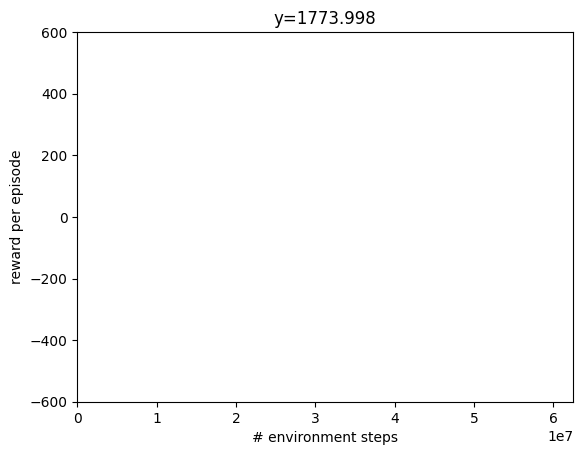

In [ ]:
envs.register_environment('walker_ernest', HumanoidWalker)
env = envs.get_environment('walker_ernest') #, xml_path='assets/humanoid/humanoid_pos.xml')

drive_dir = '/content/drive/MyDrive/RoboCup'

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)


train_fn = functools.partial(
    ppo.train, num_timesteps=50_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=24, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=3072,
    batch_size=512, seed=0)




x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 600, -600
def progress(num_steps, metrics):
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics['eval/episode_reward'])
    ydataerr.append(metrics['eval/episode_reward_std'])
    print(f'Metrics: {metrics}')

    plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
    plt.ylim([min_y, max_y])

    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.title(f'y={y_data[-1]:.3f}')

    plt.errorbar(
        x_data, y_data, yerr=ydataerr)
    plt.savefig(drive_dir + '/output/longtrain.png')

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)
model.save_params(drive_dir + '/output/params', params)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

Visualization

In [ ]:
# # Run these commands at the start of your notebook
# !apt-get update -y
# !apt-get install -y xvfb mesa-utils
# !apt-get install -y python-opengl
# !apt-get install -y x11-utils

# # Set the correct OpenGL backend for Mujoco
# import os
# os.environ['MUJOCO_GL'] = 'egl'
# os.environ['PYOPENGL_PLATFORM'] = 'egl'

# # Start Xvfb with specific parameters
# !start-stop-daemon --start --background --exec /usr/bin/Xvfb -- :1 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

# # Set the display
# os.environ['DISPLAY'] = ':1'

# # Verify OpenGL is working
# !DISPLAY=:1 glxinfo | grep "OpenGL"

In [ ]:

# model_path = drive_dir + '/output/params'
# params = model.load_params(model_path)

# inference_fn = make_inference_fn(params)
# jit_inference_fn = jax.jit(inference_fn)

# eval_env = envs.get_environment('kicker')
# jit_reset = jax.jit(eval_env.reset)
# jit_step = jax.jit(eval_env.step)

# rng = jax.random.PRNGKey(0)
# state = jit_reset(rng)
# rollout = [state.pipeline_state]

# n_steps = 1000
# render_every = 2

# for i in range(n_steps):
#   act_rng, rng = jax.random.split(rng)
#   ctrl, _ = jit_inference_fn(state.obs, act_rng)
#   state = jit_step(state, ctrl)
#   rollout.append(state.pipeline_state)

#   if state.done:
#     break

# media.show_video(env.render(rollout[::render_every], camera='side'), fps=1.0 / env.dt / render_every)